In [1]:
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math


In [20]:
src = cv2.imread("./images/4.png")
src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)


In [21]:
(H, W) = src.shape[:2]

x_offset = W % 32
y_offset = H % 32
new_x_start = math.floor(x_offset / 2)
new_x_end = W - math.ceil(x_offset / 2)
new_y_start = math.floor(y_offset / 2)
new_y_end = H - math.ceil(y_offset / 2)

src = src[new_y_start:new_y_end, new_x_start:new_x_end]
orig = src.copy()
(H, W) = src.shape[:2]

In [22]:
layers = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

blob = cv2.dnn.blobFromImage(src, 1.0, (W, H),
	(127, 127, 127), swapRB=False, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layers)
end = time.time()

print("Text detection took {:.6f} seconds".format(end - start))

Text detection took 0.276151 seconds


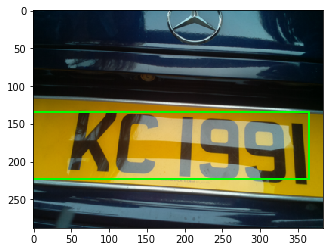

In [23]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
for y in range(0, numRows):
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	for x in range(0, numCols):
		# Ignore low probability predictions
		if scoresData[x] < 0.5:
			continue
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		if h * w < 1000:
			continue
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

boxes = non_max_suppression(np.array(rects), probs=confidences)
demo = orig.copy()
points = []
for (startX, startY, endX, endY) in boxes:
	cv2.rectangle(demo, (startX, startY), (endX, endY), (0, 255, 0), 2)
	points.append((startX, startY))
	points.append((endX, endY))
plt.imshow(demo)
plt.show()

(-19, 134, 385, 90)


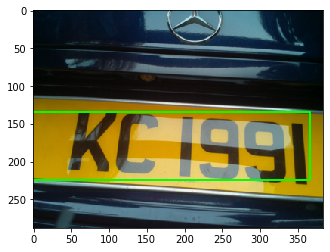

In [31]:
rect = cv2.boundingRect(np.array(points))
x,y,w,h = rect
rect_demo = orig.copy()
cv2.rectangle(rect_demo, (x, y), (x+w, y+h), (0,255,0), 2)
plt.imshow(rect_demo)
plt.show()

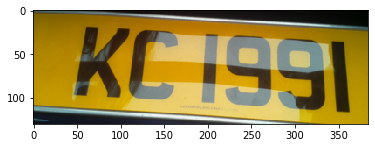

In [36]:
dilate_offset = 20
plate = orig[max(y-dilate_offset, 0):min(y+h+dilate_offset, H), max(x-dilate_offset, 0):min(x+w+dilate_offset, W)]
plt.imshow(plate)
plt.show()